In [24]:
import dill
from sklearn import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import common_functions as cf
import importlib
importlib.reload(cf)

ARRAY_SIZE = 4
MODEL_NAME = "H1_5-2x2"
SENSOR_LAG = 25
DATA_NAME = "H1_5_sil5_2D"

models = []

# Load the models
taxel_models = dill.load(open(os.path.join(os.getcwd(), f'../models/PolyLinear-Deg4/{MODEL_NAME}'), 'rb'))
taxel_models

In [25]:
# Load sensor data file including silicone
TFdata = cf.read_csv_file(f"../scripts/FT300-S_force_torque/data/{DATA_NAME}.csv") 
sensordata = cf.read_csv_file(f'../scripts/2x2_sensor/data/{DATA_NAME}.csv')

# Time sync
data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

# Remove mean of first 100 samples
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]
data = cf.offset_data(data, data_columns, 100)

# Remove rows containing NaN values
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22038 entries, 1 to 22038
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    22038 non-null  int64  
 1   t_wall   22038 non-null  float64
 2   X0       22038 non-null  float64
 3   Y0       22038 non-null  float64
 4   Z0       22038 non-null  float64
 5   X1       22038 non-null  float64
 6   Y1       22038 non-null  float64
 7   Z1       22038 non-null  float64
 8   X2       22038 non-null  float64
 9   Y2       22038 non-null  float64
 10  Z2       22038 non-null  float64
 11  X3       22038 non-null  float64
 12  Y3       22038 non-null  float64
 13  Z3       22038 non-null  float64
 14  t_robot  22038 non-null  float64
 15  F_x      22038 non-null  float64
 16  F_y      22038 non-null  float64
 17  F_z      22038 non-null  float64
 18  T_x      22038 non-null  float64
 19  T_y      22038 non-null  float64
 20  T_z      22038 non-null  float64
dtypes: float64(2

In [26]:
# Predict forces
for i in range(ARRAY_SIZE):
    
  # Predict
  X = data[[f'X{i}', f'Y{i}', f'Z{i}']]
  Y = taxel_models[i].predict(X.to_numpy())
  
  # add to PD
  data[f'F_x{i}'] = Y[:, 0]
  data[f'F_y{i}'] = Y[:, 1]
  data[f'F_z{i}'] = Y[:, 2]

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/s

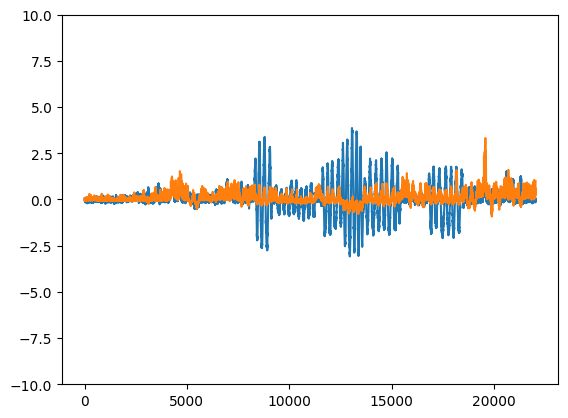

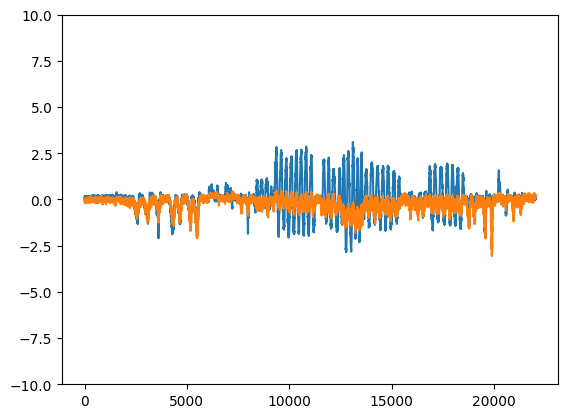

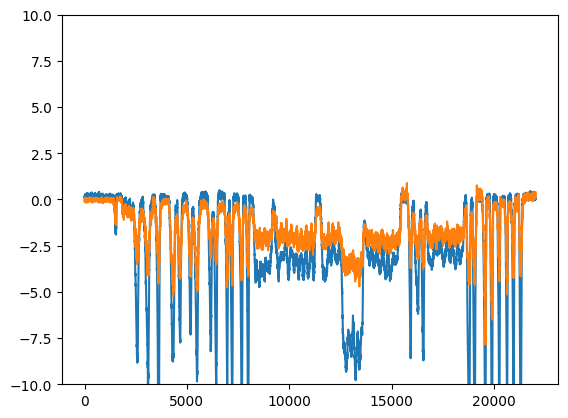

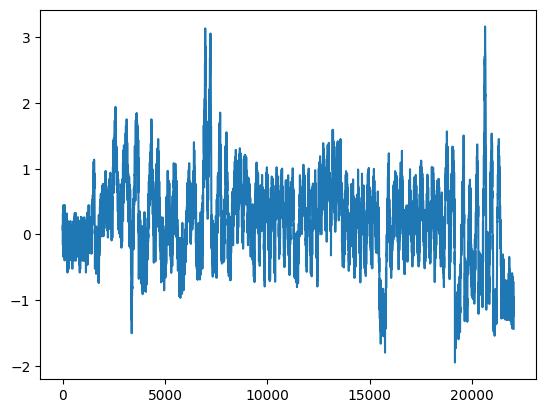

In [27]:
for letter in ['x', 'y', 'z']:
  plt.plot(data[f'F_{letter}'])
  plt.plot(data[f'F_{letter}0']+ data[f'F_{letter}1'] + data[f'F_{letter}2'] + data[f'F_{letter}3'])
  # plt.xlim(10000, 15000)
  plt.ylim(-10,10)
  plt.show()
  
plt.plot(data[f'Z0'])
# plt.xlim(10000, 15000)
plt.show()
  